In [ ]:
# On Google colab, we must ensure scipy is up to date
!pip install -U scipy==1.5.3

In [1]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.sparse
from joblib import Parallel, delayed
from enum import Enum

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from matplotlib.ticker import PercentFormatter


plt.style.use('ggplot')

## Download Data

In [2]:
def download_dataset():
  urllib.request.urlretrieve(
      "https://s3-eu-west-1.amazonaws.com/attribution-dataset/criteo_attribution_dataset.zip", 
      "criteo_attribution_dataset.zip"
  )
  
  with zipfile.ZipFile("criteo_attribution_dataset.zip", "r") as zip_ref:
    zip_ref.extractall("criteo_attribution_dataset")

In [3]:
dataset_path = 'criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'

if not os.path.exists(dataset_path):
  download_dataset()

cache_mtc_results_dir = 'cache_mtc_results_dir'
os.makedirs(cache_mtc_results_dir, exist_ok=True)

## Preprocessing

### Take a data sample
In order to run the code on Google colab or a personal computer, we might want to sub-sample a part of the user timelines.

In [4]:
df = pd.read_csv(dataset_path, sep='\t', compression="gzip")

In [5]:
debug_sample = 1.0

uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_sampling'
hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
debug_df = df[random_column_based_on_uid < debug_sample]
debug_df

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468022,2671199,5767906,4869923,0,-1,-1,0,1,-1,-1,...,482560,30763035,26597095,13113052,29196072,5824236,30763035,18391143,29196072,8661623
16468023,2671199,6852682,10002432,0,-1,-1,0,0,-1,-1,...,971748,25259032,9312274,10979162,29196072,32440044,29196072,27259439,29196072,8661620
16468024,2671199,16638720,7061828,0,-1,-1,0,0,-1,-1,...,268431,30763035,5824235,29542751,29196072,5824237,29196072,3696777,29196072,21091111
16468025,2671199,3032300,5061834,0,-1,-1,0,1,-1,-1,...,-1,1973606,26597096,28944164,29196072,26611392,1973606,5642940,14911188,29196072


### Clean timelines
Split timelines having multiple conversions and remove timelines that have missing clicks

In [6]:
def split_timelines(df):
  """Some timelines have several conversions and conversion times.
  For the sake of simplicity, we split the timelines as soon as a conversion occurs.
  """
  conversion_timestamps = df.groupby('uid').agg({'conversion_timestamp': lambda x: sorted(list(set(x)))})
  conversion_timestamps.rename(columns={'conversion_timestamp': 'conversion_timestamps'}, inplace=True)

  def get_next_conversion_timestamp(data):
    next_conversion_index = np.searchsorted(data['conversion_timestamps'], data['timestamp'])
    if next_conversion_index == len(data['conversion_timestamps']):
      return 'nnc' # no next conversion
    else:
      return str(data['conversion_timestamps'][next_conversion_index])

  df_with_ct = df.merge(conversion_timestamps, on='uid', how='outer', validate="many_to_one")

  matched_displays_mask = df_with_ct['conversion_timestamp'] > 0
  df_with_ct['next_conversion_timestamp'] = np.where(
      matched_displays_mask,
      df_with_ct['conversion_timestamp'].astype(str),
      df_with_ct.apply(get_next_conversion_timestamp, axis=1)
  )
  
  df_with_ct.rename(columns={'uid': 'uid_no_split'}, inplace=True)
  df_with_ct['uid'] = df_with_ct['uid_no_split'].astype(str) + '_' + df_with_ct['next_conversion_timestamp']
  
  original_column_order = list(df.columns)
  return df_with_ct[original_column_order]

In [7]:
debug = True
if debug:
  test_df = pd.DataFrame([
      {'uid': 1, 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': 1, 'timestamp': 2, 'conversion_timestamp': -1},
      {'uid': 1, 'timestamp': 3, 'conversion_timestamp': 6},
      {'uid': 1, 'timestamp': 4, 'conversion_timestamp': 6},
      {'uid': 1, 'timestamp': 7, 'conversion_timestamp': -1},
      {'uid': 1, 'timestamp': 8, 'conversion_timestamp': 10},
      {'uid': 1, 'timestamp': 9, 'conversion_timestamp': 10},
      {'uid': 1, 'timestamp': 11, 'conversion_timestamp': -1},
      {'uid': 1, 'timestamp': 12, 'conversion_timestamp': -1},
      {'uid': 2, 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': 2, 'timestamp': 2, 'conversion_timestamp': -1},
      # Edge case : sometimes (rarely, the conversion is not mapped to the next one)
      {'uid': 3, 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': 3, 'timestamp': 2, 'conversion_timestamp': 7},
      {'uid': 3, 'timestamp': 3, 'conversion_timestamp': 4},
      {'uid': 3, 'timestamp': 5, 'conversion_timestamp': 7},
      {'uid': 3, 'timestamp': 6, 'conversion_timestamp': 7},
  ])
  split_test_df = pd.DataFrame([
      {'uid': '1_6', 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': '1_6', 'timestamp': 2, 'conversion_timestamp': -1},
      {'uid': '1_6', 'timestamp': 3, 'conversion_timestamp': 6},
      {'uid': '1_6', 'timestamp': 4, 'conversion_timestamp': 6},
      {'uid': '1_10', 'timestamp': 7, 'conversion_timestamp': -1},
      {'uid': '1_10', 'timestamp': 8, 'conversion_timestamp': 10},
      {'uid': '1_10', 'timestamp': 9, 'conversion_timestamp': 10},
      {'uid': '1_nnc', 'timestamp': 11, 'conversion_timestamp': -1},
      {'uid': '1_nnc', 'timestamp': 12, 'conversion_timestamp': -1},
      {'uid': '2_nnc', 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': '2_nnc', 'timestamp': 2, 'conversion_timestamp': -1},
      # Edge case
      {'uid': '3_4', 'timestamp': 1, 'conversion_timestamp': -1},
      {'uid': '3_7', 'timestamp': 2, 'conversion_timestamp': 7},
      {'uid': '3_4', 'timestamp': 3, 'conversion_timestamp': 4},
      {'uid': '3_7', 'timestamp': 5, 'conversion_timestamp': 7},
      {'uid': '3_7', 'timestamp': 6, 'conversion_timestamp': 7},
  ])
  assert split_test_df.equals(split_timelines(test_df))

In [8]:
def remove_uncomplete_timelines(df):
  """Since the data set consists of 30 consecutive days, it contains some timelines that
  had started before and hence are uncomplete in our training example.
  For the sake of simplicity, we remove them.
  """
  # First assert that for all timelines, if a display is associated to a conversion (click_nb > 0)
  # then, all click displays share the same click number
  click_nb_check_df = df[df['click_nb'] > 0].groupby('uid').agg({'click_nb': lambda x: len(set(x))})
  assert np.all(click_nb_check_df['click_nb'] == 1)

  click_nb_in_timelines = df.groupby('uid').agg({'click': 'sum'})
  click_nb_in_timelines.rename(columns={'click': 'click_nb_in_timeline'}, inplace=True)

  df_with_click_nb = df.merge(click_nb_in_timelines, on='uid', how='outer', validate="many_to_one")

  # We keep if there is either no click or if all clicks are available
  keep_display = (df_with_click_nb['click_nb'] == -1) | (df_with_click_nb['click_nb_in_timeline'] == df_with_click_nb['click_nb'])
  filtered_df = df_with_click_nb[keep_display].reset_index()

  original_column_order = df.columns
  return filtered_df[original_column_order]

In [9]:
debug = True
if debug:
  # TODO: maybe it makes more sense to remove the whole uncomplete timeline
  test_df = pd.DataFrame([
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 2, 'click': 0, 'click_nb': -1},
      {'uid': 2, 'click': 1, 'click_nb': 2},
      {'uid': 2, 'click': 1, 'click_nb': 2},
      {'uid': 3, 'click': 1, 'click_nb': 3},
      {'uid': 3, 'click': 1, 'click_nb': 3},
      {'uid': 3, 'click': 0, 'click_nb': -1},
  ])
  removed_uncomplete_test_df = pd.DataFrame([
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 1, 'click': 0, 'click_nb': -1},
      {'uid': 2, 'click': 0, 'click_nb': -1},
      {'uid': 2, 'click': 1, 'click_nb': 2},
      {'uid': 2, 'click': 1, 'click_nb': 2},
      {'uid': 3, 'click': 0, 'click_nb': -1},
  ])
  assert removed_uncomplete_test_df.equals(remove_uncomplete_timelines(test_df))

In [10]:
def get_nb_clicks(df, time_window=60*60*24):
    click_timestamps = df[df['click'] == 1].groupby('uid').agg({'timestamp': lambda x: sorted(list(set(x)))})
    click_timestamps.rename(columns={'timestamp': 'click_timestamps'}, inplace=True)

    def get_nb_clicks(data):
        if isinstance(data['click_timestamps'], list) and len(data['click_timestamps']) > 0:
            return np.searchsorted(data['click_timestamps'], data['timestamp'])
        else:
            return 0

    df_with_ct = df.merge(click_timestamps, on='uid', how='outer', validate="many_to_one")
    df_with_ct['nb_clicks'] = df_with_ct.apply(get_nb_clicks, axis=1)
    
    original_column_order = list(df.columns) + ['nb_clicks']
    return df_with_ct[original_column_order]

In [11]:
debug = True
if debug:
    test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'click': 0},
        {'uid': 1, 'timestamp': 2, 'click': 0},
        {'uid': 1, 'timestamp': 3, 'click': 1},
        {'uid': 1, 'timestamp': 4, 'click': 1},
        {'uid': 1, 'timestamp': 7, 'click': 0},
        {'uid': 1, 'timestamp': 8, 'click': 1},
        {'uid': 1, 'timestamp': 9, 'click': 1},
        {'uid': 1, 'timestamp': 11, 'click': 0},
        {'uid': 1, 'timestamp': 12, 'click': 0},
        {'uid': 2, 'timestamp': 1, 'click': 0},
        {'uid': 2, 'timestamp': 2, 'click': 0},
    ])
    nb_clicks_test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 3, 'click': 1, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 4, 'click': 1, "nb_clicks": 1},
        {'uid': 1, 'timestamp': 7, 'click': 0, "nb_clicks": 2},
        {'uid': 1, 'timestamp': 8, 'click': 1, "nb_clicks": 2},
        {'uid': 1, 'timestamp': 9, 'click': 1, "nb_clicks": 3},
        {'uid': 1, 'timestamp': 11, 'click': 0, "nb_clicks": 4},
        {'uid': 1, 'timestamp': 12, 'click': 0, "nb_clicks": 4},
        {'uid': 2, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
        {'uid': 2, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
    ])

    assert nb_clicks_test_df.equals(get_nb_clicks(test_df))

### Enrich dataset

In [12]:
def preprocess_dataframe(input_df, refresh=False):
  df_identifier = '_'.join(map(str, input_df.shape))
  cache_directory = 'cache'
  cache_path = os.path.join(cache_directory, df_identifier, 'preprocess.pkl')
  if os.path.exists(cache_path) and not refresh:
    df = pd.read_pickle(cache_path)

  else:
    df = input_df.copy()
    df['uid'] = df['uid'].astype(str) + '_' + df['campaign'].astype(str)

    df = split_timelines(df)

    df = remove_uncomplete_timelines(df)

    df['day'] = np.floor(df['timestamp'] / 86400.).astype(int)

    df['time_since_last_click_bucketized'] = np.where(
      df['time_since_last_click'] == -1, -1,
      np.where(
          df['time_since_last_click'] < 20 * 3600,
          np.log(1 + df['time_since_last_click'] / 60).astype(int),
          7 + (df['time_since_last_click'] / (2 * 24 * 3600)).astype(int)
      )
    )

    df['gap_click_sale'] = -1
    df.loc[df['conversion'] == 1, 'gap_click_sale'] = df['conversion_timestamp'] - df['timestamp']

    df['last_click'] = df['attribution'] * (df['click_pos'] == df['click_nb'] - 1).astype(int)
    
    # TODO : this is not really first click, if attribution happens too late...
    df['first_click'] = df['attribution'] * (df['click_pos'] == 0).astype(int)
    df['uniform'] = df['attribution'] / (df['click_nb']).astype(float)
    
    total_uid_reward = df.groupby('uid').agg({'last_click': 'sum'})
    total_uid_reward.columns = ['total_uid_rewards']
    
    df = df.merge(total_uid_reward, on='uid', how='outer', validate="many_to_one")
    df = get_nb_clicks(df)
    
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    df.to_pickle(cache_path)
  
  # assert there is at most one conversion per timeline
  assert set(df['total_uid_rewards'].unique()) == {0, 1}

  return df

In [13]:
%%time

enriched_df = preprocess_dataframe(debug_df, refresh=False)

CPU times: user 2.32 s, sys: 2.39 s, total: 4.71 s
Wall time: 4.92 s


### Dataset statistics

In [14]:
n_timelines = len(enriched_df)
n_users = len(enriched_df['uid'].unique())
n_conversions = sum(enriched_df['total_uid_rewards'])
print(f'The dataset consists in {n_timelines} timelines of {n_users} users among which {n_conversions} converted')

The dataset consists in 16256483 timelines of 8015218 users among which 478156 converted


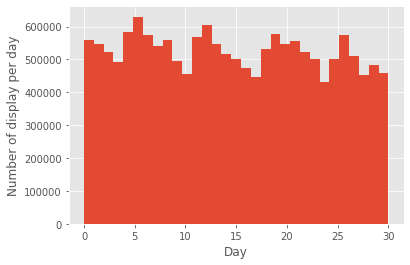

In [15]:
enriched_df.day.hist(bins=len(enriched_df.day.unique()))
plt.ylabel('Number of display per day')
plt.xlabel('Day')
None

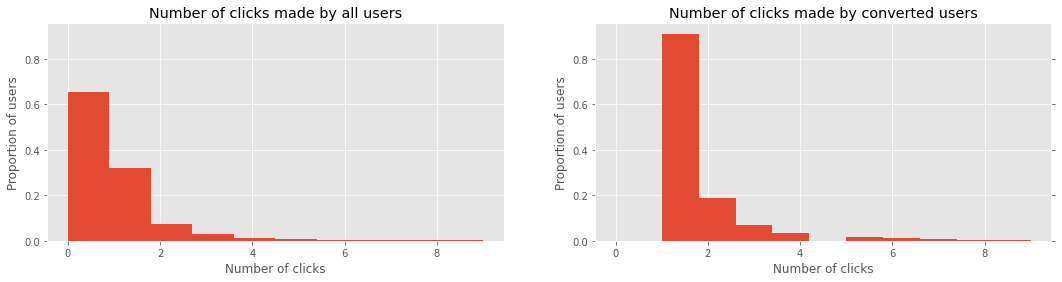

In [16]:
groupped_by_user = enriched_df.groupby('uid').agg({'click': ['count', 'sum'], 'attribution': ['sum']})
converted_users = groupped_by_user[groupped_by_user['attribution']['sum'] > 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharex=True, sharey=True)
max_clicks = 10
groupped_by_user['click']['sum'][groupped_by_user['click']['sum'] < max_clicks].hist(density=True, bins=max_clicks, ax=axes[0])
axes[0].set_title('Number of clicks made by all users')
axes[0].set_xlabel('Number of clicks')
axes[0].set_ylabel('Proportion of users')

converted_users['click']['sum'][converted_users['click']['sum'] < max_clicks].hist(density=True, bins=max_clicks, ax=axes[1])
axes[1].set_title('Number of clicks made by converted users')
axes[1].set_xlabel('Number of clicks')
axes[1].yaxis.set_tick_params(reset=True)
axes[1].set_ylabel('Proportion of users')
None

### Featuring

In [17]:
def split_train_test_mask(df, ratio):
  """We split the dataset into train and test parts by uid
  (learn on a part of the population and test on the other part)
  """
  uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_train_test_split'
  hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
  random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
  return random_column_based_on_uid < ratio

In [18]:
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'time_since_last_click_bucketized', 'nb_clicks']
CACHE_DIRECTORY = 'cache'
LABELS_FILE = 'labels.npy'
FEATURES_FILE = 'features.npz'

def features_to_list_of_strings(row):
  return [f'{feature}_{row[feature]}' for feature in row.index]

def get_labels_and_features(df, label_column, hash_space=2**13, refresh=False):
  df_identifier = '_'.join(map(str, enriched_df.shape))
  label_features_identifier = f'{label_column}_{"_".join(FEATURES)}'
  cache_path = os.path.join(CACHE_DIRECTORY, df_identifier, label_features_identifier, str(hash_space))
  label_cache_path = os.path.join(cache_path, LABELS_FILE)
  features_cache_path = os.path.join(cache_path, FEATURES_FILE)
  
  if not refresh and os.path.exists(label_cache_path) and os.path.exists(features_cache_path):
    labels = np.load(label_cache_path)
    features = scipy.sparse.load_npz(features_cache_path)

  else:
    labels = df[label_column].astype(float).values
    raw_features = df[FEATURES]

    features_as_list_of_strings = raw_features.apply(features_to_list_of_strings, axis=1)
    hasher = FeatureHasher(n_features=hash_space, input_type='string', alternate_sign=False)
    features = hasher.fit_transform(features_as_list_of_strings)
    os.makedirs(cache_path, exist_ok=True)
    np.save(label_cache_path, labels)
    scipy.sparse.save_npz(features_cache_path, features)

  return labels, features

In [19]:
hash_space = 2**13

labels, features = get_labels_and_features(
    enriched_df, 'last_click', hash_space=hash_space, refresh=False)
is_training = split_train_test_mask(enriched_df, 0.8)
train_labels, train_features = labels[is_training], features[is_training]

## MTC Likelihood

We call MTC empirical likelihood 

$$
f(\nu) = \sum_{n = 1}^N \Bigg\{ V(s_n) \cdot \log \bigg( \sum_{i = 1}^{\ell(s)} \nu({s_n}^i) \bigg) - \sum_{i = 1}^{\ell(s)} \nu({s_n}^i) \Bigg\}
$$

In [20]:
def mtc_likelihood(model_or_predictions, features, timeline_ids, uid_rewards):
  # Get model predictions for all displays
  if hasattr(model_or_predictions, 'predict_proba'):
    model_predictions = model_or_predictions.predict_proba(features)[:, 1]
  else:
    model_predictions = model_or_predictions

  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
      'timeline_id': timeline_ids,
      'prediction': model_predictions,
      'uid_reward': uid_rewards,
  })

  sum_predictions_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg({'prediction': 'sum', 'uid_reward': 'first'})
    .reset_index()
  )
  sum_predictions_by_timeline.columns = ['timeline_id', 'sum_predictions', 'uid_reward']
    
  mtc_llh = (
    sum_predictions_by_timeline['uid_reward'] 
    * np.log(sum_predictions_by_timeline['sum_predictions'])
    - sum_predictions_by_timeline['sum_predictions']
  )
  
  return mtc_llh.mean()

## Learning

In [21]:
C_REGULARIZATION = 1

### One pass / classical learning

In [22]:
%%time
last_touch_model = LogisticRegression(max_iter=1000, C=C_REGULARIZATION)
last_touch_model.fit(train_features, train_labels)

CPU times: user 16min 56s, sys: 1min 53s, total: 18min 50s
Wall time: 18min 49s


LogisticRegression(C=1, max_iter=1000)

### Core Attribution

#### Logistic regression with continuous labels

We choose Logistic regression from scikit-learn as our ML algorithm. The logistic regression loss that we minimize is

$$
l(y, p) = \mathbb{1}_{y = 1} \log(p) + \mathbb{1}_{y = 0} \log(1 - p)
$$

However, our fixed-point algorithm will make appear continuous labels ($y$ is the result of the internal attribution $\mu$) that cannot be fit with scikit-learn's logistic regression. Indeed, this logisitic regression can only take 0-1 labels as input.

A basic extension of logistic regression to learn with a continuous label $y \in [0, 1]$, consisits in minimizing the binomial loss that writes:

$$
l(y, p) = y \log(p) + (1 - y) \log(1 - p)
$$

In order to minimize this loss with a logistic regression optimizer, we generate a new dataset in which we duplicate the rows and assign them a weight : a "positive" row a label 1 and a weight $y$ and a "negative" row with a label 0 and a weight $1 - y$.

In [23]:
class CountinuousLogisticRegression(LogisticRegression):
  
  @staticmethod
  def from_countinuous_to_weighted_binary_labels(labels, features):
    """Transforms a dataset with continuous labels into a bigger dataset with weighted 
    binary labels. See explanation above.
    """
    weigths_positive = labels
    weigths_negative = 1 - labels
    label_positive = np.ones_like(labels)
    label_negative = np.zeros_like(labels)

    weights = np.hstack((weigths_positive, weigths_negative))
    weighted_labels = np.hstack((label_positive, label_negative))
    weighted_features = scipy.sparse.vstack((features, features))

    mask = (weights > 0)
    return weighted_labels[mask], weighted_features[mask], weights[mask]
  
  def fit(self, X, y):
    # 1. Generate dataset, use continuous labels to weighted dataset trick
    weighted_labels, weighted_features, weights = self.from_countinuous_to_weighted_binary_labels(y, X)

    # 2. Train model
    return LogisticRegression.fit(self, weighted_features, weighted_labels, sample_weight=weights)

#### Fixed point iterations

We are implementing the following fixed-point algorithm

1. Generate dataset
   $$ \mathcal{D}^{(k + 1)} \;\; = \;\; \big\{
   (x, y) = \big((s_n)^j, \mu^{(k)}(j, s_n) \big) \text{ for } n \in [N] \text{ and } j \in [\ell(s_n)] 
   \big\}$$
  
2. With a ML algorithm, train $\nu^{(k + 1)}$ on $\mathcal{D}^{(k + 1)}$ \\
   $$ \nu^{(k + 1)} \;\; = \;\; (s) \mapsto \mathbb{E}_{(x, y) \in \mathcal{D}^{(k + 1)}} \big[ y\; | \; x=s \big] $$

3. Set $\mu$ with fixed-point characterization 
   $$\mu^{(k + 1)} \;\; = \;\; (i, s) \mapsto \frac{\nu^{(k + 1)}(s^i)}{\sum_{j = 1}^{\ell(s)} \nu^{(k + 1)}(s^j)} V(s)$$

In [24]:
def split_dataset_into_static_and_to_update_parts(df):
  """In our dataset, we know in advance that many displays will not get any 
  credit from the internal attribution. Either:
    1. because they have not been clicked or have been clicked only once
    2. because no attributed sales were corresponding to this uid.
  These displays remain attached with a zero label while the remaining ones
  will have a variable label computed with the fixed point iterations.
  """
  to_update_mask = ((df['total_uid_rewards'] > 0) & (df['click'] >= 1)).values

  static_mask = ~to_update_mask
  return to_update_mask, static_mask


def run_one_iteration(model, labels, features, is_clicked, uids, total_uid_reward, kernel_values=None):
  """In our dataset, we know in advance that many displays will not get any 
  credit from the internal attribution. Either:
    1. because they have not been clicked or have been clicked only once
    2. because no attributed sales were corresponding to this uid.
  These displays remain attached with a zero label while the remaining ones
  will have a variable label computed with the fixed point iterations.
  """
  to_update_mask = (total_uid_reward > 0) & is_clicked
  static_mask = ~to_update_mask

  labels_to_update, features_to_update = labels[to_update_mask], features[to_update_mask]
  
  # Step 2, compute valuations
  if model is None:
    model = CountinuousLogisticRegression(max_iter=1000, C=C_REGULARIZATION)
  model.fit(features, labels)
  model_predictions = model.predict_proba(features_to_update)[:, 1]

  if kernel_values is None:
    scenario_valuation = model_predictions
  else:
    scenario_valuation = model_predictions * kernel_values[to_update_mask]

  predictions_per_display_to_update = pd.DataFrame({
      'feature_index': np.arange(scenario_valuation.shape[0]), 
      'uid': uids[to_update_mask],
      'scenario_valuation': scenario_valuation,
      'total_uid_rewards': total_uid_reward[to_update_mask],
  })
  
  # Step 3, compute new labels proportionnaly to the display valuations
  total_uid_valuation = (
      predictions_per_display_to_update
      .groupby('uid')
      .agg(total_uid_valuation=('scenario_valuation', 'sum'))
      .reset_index()
  )
  
  predictions_per_display_to_update = predictions_per_display_to_update.merge(
      total_uid_valuation, on='uid', how='left')
  
  # merge shuffles the lines, we must reorder them by feature index
  predictions_per_display_to_update.sort_values('feature_index', inplace=True)

  # Use fixed point characterization to update the labels
  updated_labels = (
    predictions_per_display_to_update['scenario_valuation'] 
    / predictions_per_display_to_update['total_uid_valuation'] 
    * predictions_per_display_to_update['total_uid_rewards']
  ).values

  next_labels = labels
  next_labels[to_update_mask] = updated_labels

  # Ensure we have just spread the labels
  np.testing.assert_almost_equal(sum(updated_labels), sum(labels))
  np.testing.assert_almost_equal(sum(next_labels), sum(labels))
  
  return model, next_labels

In [25]:
scenario_valuations_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', f'senario_valuations_C={C_REGULARIZATION}.csv')
mtc_likelihoods_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', f'mtc_likelihoods_C={C_REGULARIZATION}.csv')
mtc_likelihoods_with_hashspace_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', f'mtc_likelihoods_with_hashspace_C={C_REGULARIZATION}.csv')
metrics_with_hashspace_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', f'metrics_with_hashspace_C={C_REGULARIZATION}.csv')

In [ ]:
%%time
scenario_valuations = []
mtc_likelihoods = []
penalized_mtc_likelihoods = []
test_mtc_likelihoods = []
test_penalized_mtc_likelihoods = []
current_model, current_labels = None, labels[is_training].astype(float).copy()

n_selected_displays = 10
selected_displays = (current_labels > 0) & (np.cumsum(current_labels) < n_selected_displays)
is_clicked, uids, total_uid_rewards = enriched_df['click'] > 0, enriched_df['uid'], enriched_df['total_uid_rewards']
for _ in range(10):
  print(_)
  current_model, current_labels = run_one_iteration(
      current_model, current_labels, train_features, is_clicked[is_training], uids[is_training], total_uid_rewards[is_training])
  
  mtc_likelihoods += [mtc_likelihood(current_model, train_features, uids[is_training], total_uid_rewards[is_training])]
  test_mtc_likelihoods += [mtc_likelihood(current_model, features[~is_training], uids[~is_training], total_uid_rewards[~is_training])]

  solver_coeffs = current_model.coef_.ravel()
  penalization = 0.5 / current_model.C * np.dot(solver_coeffs, solver_coeffs)
  penalized_mtc_likelihoods += [mtc_likelihoods[-1] - penalization / train_features.shape[0]]
  test_penalized_mtc_likelihoods += [test_mtc_likelihoods[-1] - penalization / features[~is_training].shape[0]]
  scenario_valuations += [{
    f'Display {i}': current_model.predict_proba(feature)[0, 1]
    for i, feature in enumerate(train_features[selected_displays])
  }]

mtc_model = current_model

os.makedirs(os.path.dirname(scenario_valuations_path), exist_ok=True)
pd.DataFrame(scenario_valuations).to_csv(scenario_valuations_path, index=False)
pd.DataFrame({
    'mtc_likelihoods': mtc_likelihoods, 'test_mtc_likelihoods': test_mtc_likelihoods,
    'penalized_mtc_likelihoods': penalized_mtc_likelihoods, 'test_penalized_mtc_likelihoods': test_penalized_mtc_likelihoods,
}).to_csv(mtc_likelihoods_path, index=False)

0
1
2
3


In [ ]:
def plot_scenario_valuation(scenario_valuations_df, ax):
  display_types = sorted(list(scenario_valuations_df.columns))
  for display_type in display_types:
    ax.plot(scenario_valuations_df[display_type], label=display_type)

  ax.set_title('Convergence of display valuations')
  ax.set_ylabel('display valuation')
  ax.set_xlabel('iteration number')
  ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1] * 1.2))  # Add some space on the right
  ax.set_ylim([0., ax.get_ylim()[1] + 0.3 * (ax.get_ylim()[1] - ax.get_ylim()[0])])
  ax.legend(loc='upper right', ncol=3)

fig, ax = plt.subplots(1, 1)
scenario_valuations_df = pd.read_csv(scenario_valuations_path)
plot_scenario_valuation(scenario_valuations_df, ax)

In [ ]:
def plot_mtc_likelihood(mtc_likelihoods, ax):
  ax.plot(range(1, len(mtc_likelihoods) + 1), mtc_likelihoods)
  ax.set_ylabel('Additivity likelihood', fontsize=14)
  ax.set_xlabel('Iteration number', fontsize=14)

  llh_init = mtc_likelihoods[0]
  llh_conv = mtc_likelihoods[-1]
  ax.scatter(len(mtc_likelihoods), llh_conv, s=60, label=f'core attribution', c='C0')
  ax.scatter(1, llh_init, s=60, label=f'last touch attribution', c='C1')
  ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mtc_likelihoods_df = pd.read_csv(mtc_likelihoods_path)
plot_mtc_likelihood(mtc_likelihoods_df["mtc_likelihoods"].values, axes[0])
axes[0].set_title('Convergence on train set')
plot_mtc_likelihood(mtc_likelihoods_df["test_mtc_likelihoods"].values, axes[1])
axes[1].set_title('Convergence on test set')
fig.tight_layout()

In [ ]:
# Saving figures for paper
mtc_likelihoods_df = pd.read_csv(mtc_likelihoods_path)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_mtc_likelihood(mtc_likelihoods_df["mtc_likelihoods"].values, ax)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_mtc_likelihood(mtc_likelihoods_df["test_mtc_likelihoods"].values, ax)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_on_test_set.pdf')
plt.close(fig)

### MTC likelihood improvement with features space

In [ ]:
def get_last_touch_model(train_labels, train_features):
  last_touch_model = LogisticRegression(max_iter=1000, C=C_REGULARIZATION)
  last_touch_model.fit(train_features, train_labels)
  return last_touch_model

def get_mtc_model(enriched_df, is_training, train_labels, train_features, n_iter=10):
  current_model, current_labels = None, train_labels.astype(float).copy()

  for _ in range(n_iter):
    is_clicked, uids, total_uid_rewards = enriched_df['click'] > 0, enriched_df['uid'], enriched_df['total_uid_rewards']
    current_model, current_labels = run_one_iteration(
        current_model, current_labels, train_features, is_clicked[is_training], uids[is_training], total_uid_rewards[is_training])
    
  return current_model

In [ ]:
def conversion_loss(suffix, model, features, timeline_ids, uid_rewards, delta=0.95, tops=[1000, 2000]):
  # Get model predictions for all displays
  model_predictions = model.predict_proba(features)[:, 1]

  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
      'timeline_id': timeline_ids,
      'prediction': model_predictions,
      'uid_reward': uid_rewards,
  })

  # the following is equivalent to apply compute_conversion_proba function (but much faster)
  # def compute_conversion_proba(predictions):
  #   conversion_proba_with_no_interaction = 1 - np.prod([
  #     (1 - prediction) for prediction in predictions
  #   ])
  #   decay_factor = delta ** len(predictions)
  #   return conversion_proba_with_no_interaction * decay_factor

  predictions_per_display['no_conversion'] = 1 - predictions_per_display['prediction']

  conversion_proba_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg({'no_conversion': ['prod', 'count'], 'uid_reward': 'first'})
    .reset_index()
  )

  conversion_proba_by_timeline['conversion_proba'] = (
      (1 - conversion_proba_by_timeline[('no_conversion', 'prod')])
      * (delta ** conversion_proba_by_timeline[('no_conversion', 'count')])
  )

  conversion_proba_by_timeline.sort_values('conversion_proba', ascending=False, inplace=True)
  
  total_positives = conversion_proba_by_timeline['uid_reward'].sum().values[0]
  
  precisions = []
  recalls = []
  conversion_proba_by_timeline['n_positive_in_top'] = conversion_proba_by_timeline['uid_reward'].cumsum()
  
  conversion_proba_by_timeline.to_csv(metrics_with_hashspace_path.replace('metrics_with_hashspace', f'conversion_proba_{suffix}'), index=False)

  precisions = conversion_proba_by_timeline['n_positive_in_top'] / (1 + np.arange(len(conversion_proba_by_timeline)))
  recalls = conversion_proba_by_timeline['n_positive_in_top'] / total_positives
  return precisions.iloc[tops].values, recalls.iloc[tops].values

In [ ]:
%%time

def compute_likelihoods_and_conversion_losses(hash_space, uids, total_uid_rewards, is_training, tops=[1000]):
  labels, features = get_labels_and_features(enriched_df, 'last_click', hash_space=hash_space, refresh=False)
  train_labels, train_features, train_timeline_ids, train_uid_rewards = (
      labels[is_training], features[is_training], timeline_ids[is_training], uid_rewards[is_training]
  )
  train_enriched_df = enriched_df[is_training]
  test_labels, test_features, test_timeline_ids, test_uid_rewards = (
      labels[~is_training], features[~is_training], timeline_ids[~is_training], uid_rewards[~is_training]
  )

  last_touch_model = get_last_touch_model(train_labels, train_features)  
  mtc_model = get_mtc_model(enriched_df, is_training, train_labels, train_features, n_iter=10)

  return (
      mtc_likelihood(last_touch_model, train_features, train_timeline_ids, train_uid_rewards), 
      mtc_likelihood(mtc_model, train_features, train_timeline_ids, train_uid_rewards),
      mtc_likelihood(last_touch_model, test_features, test_timeline_ids, test_uid_rewards), 
      mtc_likelihood(mtc_model, test_features, test_timeline_ids, test_uid_rewards),

      conversion_loss(f'h={hash_space}_lasttouch_train', last_touch_model, train_features, train_timeline_ids, train_uid_rewards, tops=tops),
      conversion_loss(f'h={hash_space}_mtc_train', mtc_model, train_features, train_timeline_ids, train_uid_rewards, tops=tops),
      conversion_loss(f'h={hash_space}_lasttouch_test', last_touch_model, test_features, test_timeline_ids, test_uid_rewards, tops=tops),
      conversion_loss(f'h={hash_space}_mtc_test', mtc_model, test_features, test_timeline_ids, test_uid_rewards, tops=tops),
  )

dalessandro = True

if dalessandro:
  hash_spaces = [2**space for space in range(10, 17)]
  n_jobs = len(hash_spaces)
  timeline_ids = enriched_df['uid']
  uid_rewards = enriched_df['total_uid_rewards']
  tops = list(range(100, 1100, 100))

  parallel_result = Parallel(n_jobs=n_jobs)(
      delayed(compute_likelihoods_and_conversion_losses)(hash_space, timeline_ids, uid_rewards, is_training, tops=tops) for hash_space in hash_spaces)

  (
    last_touch_likelihoods, mtc_likelihoods, test_last_touch_likelihoods, test_mtc_likelihoods,
    last_touch_precision_recall, mtc_precision_recall,
    test_last_touch_precision_recall, test_mtc_precision_recall,
  ) = zip(*parallel_result)


  last_touch_precision, last_touch_recall = list(zip(*last_touch_precision_recall))
  mtc_precision, mtc_recall = list(zip(*mtc_precision_recall))
  test_last_touch_precision, test_last_touch_recall = list(zip(*test_last_touch_precision_recall))
  test_mtc_precision, test_mtc_recall = list(zip(*test_mtc_precision_recall))

    
  pd.DataFrame({
      'hash_spaces': hash_spaces,
      'last_touch_likelihoods': last_touch_likelihoods, 
      'mtc_likelihoods': mtc_likelihoods,
      'test_last_touch_likelihoods': test_last_touch_likelihoods, 
      'test_mtc_likelihoods': test_mtc_likelihoods,
      'tops': [tops for _ in range(len(hash_spaces))],
      'last_touch_precision': last_touch_precision, 
      'last_touch_recall': last_touch_recall, 
      'mtc_precision': mtc_precision,
      'mtc_recall': mtc_recall,
      'test_last_touch_precision': test_last_touch_precision, 
      'test_last_touch_recall': test_last_touch_recall, 
      'test_mtc_precision': test_mtc_precision,
      'test_mtc_recall': test_mtc_recall,
  }).to_csv(metrics_with_hashspace_path, index=False)

In [ ]:
metrics_with_hashspace_path

In [ ]:
def load_csv_array(array):
  if ',' in array:
    return np.array([float(n) for n in eval(array)])
  else:
    return np.fromstring(array.replace('\n', '').replace('  ', ' ')[1:-1], sep=' ')

metrics_df = pd.read_csv(metrics_with_hashspace_path)
for col in ['tops', 'last_touch_precision', 'last_touch_recall', 'mtc_precision', 'mtc_recall', 'test_last_touch_precision', 'test_last_touch_recall', 'test_mtc_precision', 'test_mtc_recall']:
    metrics_df[col] = metrics_df[col].apply(load_csv_array)

In [ ]:
def plot_likelihood_given_hashspace(hash_spaces, mtc_likelihoods, last_touch_likelihoods, ax, metric_label):
  ax.plot(hash_spaces, mtc_likelihoods, label='core attribution', marker='o')
  ax.plot(hash_spaces, last_touch_likelihoods, label='last touch attribution', marker='x')

  ax.set_ylabel(metric_label, fontsize=14)
  ax.set_xlabel('Size of features space')
  ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['mtc_likelihoods'], metrics_df['last_touch_likelihoods'], axes[0], "'Additivity likelihood'")
axes[0].set_title('Likelihood on train set')
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['test_mtc_likelihoods'], metrics_df['test_last_touch_likelihoods'], axes[1], "'Additivity likelihood'")
axes[1].set_title('Likelihood on test set')

fig.tight_layout()

In [ ]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['mtc_likelihoods'], metrics_df['last_touch_likelihoods'], ax, 'Additivity likelihood')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_given_features_space_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['test_mtc_likelihoods'], metrics_df['test_last_touch_likelihoods'], ax, 'Additivity likelihood')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_given_features_space_on_test_set.pdf')
plt.close(fig)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['mtc_precision'].apply(lambda x: x[-1]), metrics_df['last_touch_precision'].apply(lambda x: x[-1]), axes[0], 'Precision on top 10K timelines')
axes[0].set_title(r'Precision on train set, $K=10.000$')
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['test_mtc_precision'].apply(lambda x: x[-1]), metrics_df['test_last_touch_precision'].apply(lambda x: x[-1]), axes[1], 'Precision on top 10K timelines')
axes[1].set_title(r'Precision on test set, $K=10.000$')
min_y_ax_test = 0.38
#axes[1].set_ylim(min_y_ax_test, axes[1].get_ylim()[1])

fig.tight_layout()

In [ ]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['mtc_precision'].apply(lambda x: x[-1]), metrics_df['last_touch_precision'].apply(lambda x: x[-1]), ax, 'Precision on top 10K timelines')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('precision_10K_given_features_space_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_likelihood_given_hashspace(metrics_df['hash_spaces'], metrics_df['test_mtc_precision'].apply(lambda x: x[-1]), metrics_df['test_last_touch_precision'].apply(lambda x: x[-1]), ax, 'Precision on top 10K timelines')
ax.set_ylim(min_y_ax_test, ax.get_ylim()[1])
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('precision_10K_given_features_space_on_test_set.pdf')
plt.close(fig)

In [ ]:
conversion_proba_by_timeline = pd.read_csv(metrics_with_hashspace_path.replace('metrics_with_hashspace_C=1', f'conversion_proba_h={2**13}_lasttouch_test_C=1'), header=[0, 1])

In [ ]:
conversion_proba_by_timeline.columns = [col if ('Unnamed' not  in col[1]) else col[0] for col in conversion_proba_by_timeline.columns ]

In [ ]:
total_positives = conversion_proba_by_timeline[('uid_reward', 'first')].sum()
precisions = conversion_proba_by_timeline['n_positive_in_top'] / (1 + np.arange(len(conversion_proba_by_timeline)))
recalls = conversion_proba_by_timeline['n_positive_in_top'] / total_positives

### Precision - recall

In [ ]:
def plot_precision_recall(mtc_recall, mtc_precision, last_touch_recall, last_touch_precision, ax):
  ax.set_ylabel('Precision', fontsize=14)
  ax.set_xlabel('Recall', fontsize=14)
  ax.plot(mtc_recall, mtc_precision, label='core attribution')
  ax.plot(last_touch_recall, last_touch_precision, label='last touch attribution')
  ax.legend(loc='upper right')

hash_space_metrics = metrics_df[metrics_df['hash_spaces'] == 2**13].iloc[0]
  
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_precision_recall(hash_space_metrics['mtc_recall'], hash_space_metrics['mtc_precision'], hash_space_metrics['last_touch_recall'], hash_space_metrics['last_touch_precision'], axes[0])
axes[0].set_title(r'Precision - Recall on train set')
plot_precision_recall(hash_space_metrics['test_mtc_recall'], hash_space_metrics['test_mtc_precision'], hash_space_metrics['test_last_touch_recall'], hash_space_metrics['test_last_touch_precision'], axes[1])
axes[1].set_title(r'Precision - Recall on test set')
None

In [ ]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_precision_recall(hash_space_metrics['mtc_recall'], hash_space_metrics['mtc_precision'], hash_space_metrics['last_touch_recall'], hash_space_metrics['last_touch_precision'], ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('precision_recall_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_precision_recall(hash_space_metrics['test_mtc_recall'], hash_space_metrics['test_mtc_precision'], hash_space_metrics['test_last_touch_recall'], hash_space_metrics['test_last_touch_precision'], ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('precision_recall_on_test_set.pdf')
plt.close(fig)

In [ ]:
hash_space_metrics = metrics_df[metrics_df['hash_spaces'] == metrics_df['hash_spaces'].values[-1]].iloc[0]

for setting in ['', 'test_']:
    fig, axes = plt.subplots(2, 2, figsize=(8, 4))

    axes[0, 0].set_title('precision')
    axes[0, 0].plot(hash_space_metrics['tops'], hash_space_metrics[f'{setting}mtc_precision'], label='MTC')
    axes[0, 0].plot(hash_space_metrics['tops'], hash_space_metrics[f'{setting}last_touch_precision'], label='last touch')
    axes[0, 0].legend()

    axes[0, 1].set_title('recall')
    axes[0, 1].plot(hash_space_metrics['tops'], hash_space_metrics[f'{setting}mtc_recall'], label='MTC')
    axes[0, 1].plot(hash_space_metrics['tops'], hash_space_metrics[f'{setting}last_touch_recall'], label='last touch')
    axes[0, 1].legend()

    axes[1, 0].set_title('precision - recall')
    axes[1, 0].plot(hash_space_metrics[f'{setting}mtc_precision'], hash_space_metrics[f'{setting}mtc_recall'], label='MTC')
    axes[1, 0].plot(hash_space_metrics[f'{setting}last_touch_precision'], hash_space_metrics[f'{setting}last_touch_recall'], label='last touch')
    axes[1, 0].legend()

    axes[1, 1].set_title('F1 score')
    axes[1, 1].plot(hash_space_metrics['tops'], 2 * hash_space_metrics[f'{setting}mtc_precision'] * hash_space_metrics[f'{setting}mtc_recall'] / (hash_space_metrics[f'{setting}mtc_precision'] + hash_space_metrics[f'{setting}mtc_recall']), label='MTC')
    axes[1, 1].plot(hash_space_metrics['tops'], 2 * hash_space_metrics[f'{setting}last_touch_precision'] * hash_space_metrics[f'{setting}last_touch_recall'] / (hash_space_metrics[f'{setting}last_touch_precision'] + hash_space_metrics[f'{setting}last_touch_recall']), label='last touch')
    axes[1, 1].legend()

    fig.tight_layout()

## Qualitative checks

### Time since last click

In [ ]:
packed_hours = 12
hour_since_last_click = (enriched_df['time_since_last_click'][is_training] / (packed_hours * 3600)).astype(int).values
hour_since_last_click *= packed_hours

tslc_mask = enriched_df['time_since_last_click'][is_training] > 0
temp_df = pd.DataFrame()
temp_df['last_touch_scores'] = last_touch_model.predict_proba(train_features[tslc_mask])[:, 1]
temp_df['mtc_scores'] = mtc_model.predict_proba(train_features[tslc_mask])[:, 1]
temp_df['scores_rel_diff'] = (temp_df['mtc_scores'] - temp_df['last_touch_scores']) / temp_df['last_touch_scores'] * 100
temp_df['hour_since_last_click'] = hour_since_last_click[tslc_mask]
temp_df = temp_df[temp_df['hour_since_last_click'] > 0]

tslc_mean_scores_df = temp_df.groupby('hour_since_last_click').mean().reset_index()

### Number of clicks

In [ ]:
temp_df = pd.DataFrame()
temp_df['last_touch_scores'] = last_touch_model.predict_proba(train_features)[:, 1]
temp_df['mtc_scores'] = mtc_model.predict_proba(train_features)[:, 1]
temp_df['scores_rel_diff'] = (temp_df['mtc_scores'] - temp_df['last_touch_scores']) / temp_df['last_touch_scores'] * 100
temp_df['nb_clicks'] = enriched_df['nb_clicks'][is_training]
nb_clicks_mean_scores_df = temp_df.groupby('nb_clicks').mean().reset_index()

### Plots

In [ ]:
tslc_mean_scores_file_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', "tslc_mean_scores_file.csv")
nb_clicks_mean_scores_file_path = os.path.join(cache_mtc_results_dir, f'sample_{debug_sample}', "nb_clicks_mean_scores_file.csv")

In [ ]:
tslc_mean_scores_df.to_csv(tslc_mean_scores_file_path)
nb_clicks_mean_scores_df.to_csv(nb_clicks_mean_scores_file_path)

In [ ]:
tslc_mean_scores_df = pd.read_csv(tslc_mean_scores_file_path)
nb_clicks_mean_scores_df = pd.read_csv(nb_clicks_mean_scores_file_path)

# rel_diff_label=r'$\frac{\mathrm{core\ attr.} - \mathrm{\ last\ touch\ attr.}}{\mathrm{last\ touch\ attr.}}$'
rel_diff_label=r'$\mathrm{Average} \left( \frac{\nu^* - \nu^{\mathrm{LT}}}{\nu^{\mathrm{LT}}} \right)$'

def plot_time_since_last_click(tslc_mean_scores_df, ax):
  n_hours = 700
  ax.plot(
    tslc_mean_scores_df['hour_since_last_click'][tslc_mean_scores_df['hour_since_last_click'] <= n_hours],
    tslc_mean_scores_df['scores_rel_diff'][tslc_mean_scores_df['hour_since_last_click'] <= n_hours],
    label=rel_diff_label
  )
  
  ax.yaxis.set_major_formatter(PercentFormatter())
  
  ax.set_xlabel('Hours since last click')
  ax.legend(fontsize=12)

    
def plot_nb_clicks(nb_clicks_mean_scores_df, ax):
  keep_x_nclicks = 21
  ax.plot(
    nb_clicks_mean_scores_df['nb_clicks'][nb_clicks_mean_scores_df['nb_clicks'] <= keep_x_nclicks], 
    nb_clicks_mean_scores_df['scores_rel_diff'][nb_clicks_mean_scores_df['nb_clicks'] <= keep_x_nclicks], 
    label=rel_diff_label,
  )
  ax.set_xlabel('Number of clicks before display')
  ax.yaxis.set_major_formatter(PercentFormatter())
  ax.legend(fontsize=12)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_time_since_last_click(tslc_mean_scores_df, axes[0])
axes[0].set_ylabel('average valuation (relative diff)')
plot_nb_clicks(nb_clicks_mean_scores_df, axes[1])

fig.tight_layout()

In [ ]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_since_last_click(tslc_mean_scores_df, ax)
ax.set_ylabel('average valuation (relative diff)')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('relative_score_given_time_since_last_click.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_nb_clicks(nb_clicks_mean_scores_df, ax)
ax.set_ylabel('average valuation (relative diff)')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('relative_score_given_nb_clicks.pdf')
plt.close(fig)

## Exponential Kernel

In [ ]:
%%time

if False:
  theta = 6.25e-6

  scenario_valuations_with_exp_decays = []
  mtc_likelihoods_with_exp_decays = []
  test_mtc_likelihoods_with_exp_decays = []
  current_model, current_labels = None, labels[is_training].astype(float).copy()

  n_selected_displays = 10
  selected_displays = (current_labels > 0) & (np.cumsum(current_labels) < n_selected_displays)
  is_clicked, uids, total_uid_rewards = enriched_df['click'] > 0, enriched_df['uid'], enriched_df['total_uid_rewards']
  kernel_values = np.exp(-theta * enriched_df["gap_click_sale"])
  for _ in range(10):
    current_model, current_labels = run_one_iteration(
        current_model, current_labels, train_features, is_clicked[is_training], uids[is_training], total_uid_rewards[is_training], kernel_values=kernel_values[is_training])
    
    mtc_likelihoods_with_exp_decays += [mtc_likelihood(current_model, train_features, uids[is_training], total_uid_rewards[is_training])]
    test_mtc_likelihoods_with_exp_decays += [mtc_likelihood(current_model, features[~is_training], uids[~is_training], total_uid_rewards[~is_training])]
    scenario_valuations_with_exp_decays += [{
      f'Display {i}': current_model.predict_proba(feature)[0, 1]
      for i, feature in enumerate(train_features[selected_displays])
    }]

  mtc_model_with_exp_decays = current_model

In [ ]:
if False:
  fig, ax = plt.subplots(1, 1)
  plot_scenario_valuation(scenario_valuations_with_exp_decays, ax)

In [ ]:
 if False:
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  plot_mtc_likelihood(mtc_likelihoods_with_exp_decays, axes[0])
  plot_mtc_likelihood(test_mtc_likelihoods_with_exp_decays, axes[1])
  fig.tight_layout()